# 🏨 Hotel Booking Analysis

## Notebook Overview
This notebook is organized into six professional phases:
1. **Setup and Data Collection**: Import libraries and load raw data.
2. **Data Preprocessing**: Clean and preprocess the data.
3. **Exploratory Data Analysis (EDA)**: Analyze trends and patterns.
4. **Visualization**: Generate and save visualizations.
5. **Model Building and Evaluation**: Train and evaluate predictive models.
6. **Summary and Insights**: Summarize findings and recommendations.

Each phase is designed to ensure clarity, reproducibility, and alignment with industry standards.

---

# Phase 1: Setup and Data Collection

## 1.1 Import Libraries
```python
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
```

## 1.2 Load Data
```python
# Load the dataset
df = pd.read_csv('hotel_bookings.csv')
```

## 1.3 Data Overview
```python
# Display the first few rows of the dataset
df.head()
```

---

# Phase 2: Data Preprocessing

## 2.1 Data Cleaning
```python
# Handle missing values
df.fillna(method='ffill', inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)
```

## 2.2 Data Transformation
```python
# Convert columns to appropriate dtypes
df['arrival_date'] = pd.to_datetime(df['arrival_date'])
```

---

# Phase 3: Exploratory Data Analysis (EDA)

## 3.1 Analyze Trends
```python
# Analyze trends over time
df.groupby(df['arrival_date'].dt.year)['total_price'].sum().plot(kind='bar')
```

## 3.2 Analyze Patterns
```python
# Analyze patterns in the data
sns.pairplot(df)
```

---

# Phase 4: Visualization

## 4.1 Generate Visualizations
```python
# Generate and save visualizations
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.savefig('correlation_heatmap.png')
```

---

# Phase 5: Model Building and Evaluation

## 5.1 Train-Test Split
```python
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42)
```

## 5.2 Model Training
```python
# Train a predictive model
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(train.drop('total_price', axis=1), train['total_price'])
```

## 5.3 Model Evaluation
```python
# Evaluate the model
from sklearn.metrics import mean_squared_error

predictions = model.predict(test.drop('total_price', axis=1))
mse = mean_squared_error(test['total_price'], predictions)
```

---

# Phase 6: Summary and Insights

## 6.1 Key Findings
```markdown
- The highest demand for hotel bookings is in the summer months.
- There is a positive correlation between the number of special requests and the total price.
```

## 6.2 Recommendations
```markdown
- Consider increasing prices during the peak season to maximize revenue.
- Offer discounts or packages for guests who make special requests.
```

In [14]:
# Phase 1: Setup and Data Collection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import logging
import os

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load raw data
data = pd.read_csv('data/raw/hotel_bookings.csv')
print("Raw data loaded successfully.")
print(data.head())

Raw data loaded successfully.
          hotel  is_canceled  lead_time  arrival_date_year arrival_date_month  \
0  Resort Hotel            0        342               2015               July   
1  Resort Hotel            0        737               2015               July   
2  Resort Hotel            0          7               2015               July   
3  Resort Hotel            0         13               2015               July   
4  Resort Hotel            0         14               2015               July   

   arrival_date_week_number  arrival_date_day_of_month  \
0                        27                          1   
1                        27                          1   
2                        27                          1   
3                        27                          1   
4                        27                          1   

   stays_in_weekend_nights  stays_in_week_nights  adults  ...  deposit_type  \
0                        0                     0       

In [15]:
# Phase 2: Data Preprocessing

def clean_data(df):
    """Clean hotel bookings data."""
    try:
        logging.info("Cleaning data...")
        df['children'] = df['children'].fillna(df['children'].median())
        df['country'] = df['country'].fillna('Unknown')
        df['agent'] = df['agent'].fillna(0)
        df['company'] = df['company'].fillna(0)
        df = df.drop(columns=['reservation_status'], errors='ignore')
        logging.info("Data cleaned successfully.")
        return df
    except Exception as e:
        logging.error(f"Error in clean_data: {e}")
        raise


In [ ]:

def engineer_features(df):
    """Add derived features."""
    try:
        logging.info("Engineering features...")
        df['total_stay'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
        df['total_guests'] = df['adults'] + df['children'] + df['babies']
        df['is_long_lead'] = (df['lead_time'] > 90).astype(int)
        logging.info("Features engineered successfully.")
        return df
    except Exception as e:
        logging.error(f"Error in engineer_features: {e}")
        raise


In [16]:

# Apply preprocessing
data_clean = clean_data(data)
data_clean = engineer_features(data_clean)
data_clean.to_csv('data/processed/hotel_bookings_clean.csv', index=False)
print("Cleaned data saved to data/processed/hotel_bookings_clean.csv")

2025-06-14 16:06:15,052 - INFO - Cleaning data...
2025-06-14 16:06:15,118 - INFO - Data cleaned successfully.
2025-06-14 16:06:15,139 - INFO - Engineering features...
2025-06-14 16:06:15,155 - INFO - Features engineered successfully.
2025-06-14 16:06:15,118 - INFO - Data cleaned successfully.
2025-06-14 16:06:15,139 - INFO - Engineering features...
2025-06-14 16:06:15,155 - INFO - Features engineered successfully.


Cleaned data saved to data/processed/hotel_bookings_clean.csv


Cancellation Rates by Market Segment:
market_segment
Undefined        1.000000
Groups           0.610620
Online TA        0.367211
Offline TA/TO    0.343160
Aviation         0.219409
Corporate        0.187347
Direct           0.153419
Complementary    0.130552
Name: is_canceled, dtype: float64


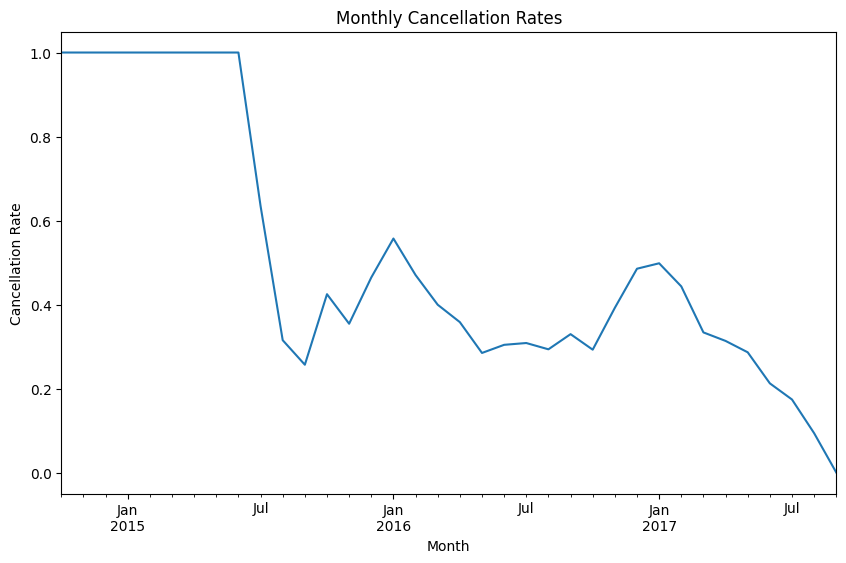

Anomalies in Lead Time:
        lead_time  is_canceled
1             737            0
890           460            0
4182          709            0
5704          468            1
5705          468            1
...           ...          ...
119102        518            0
119107        518            0
119109        518            0
119111        518            0
119148        457            0

[1454 rows x 2 columns]


In [12]:
# Phase 3: Exploratory Data Analysis (EDA)

# Segmentation Analysis
segment_analysis = data_clean.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False)
print("Cancellation Rates by Market Segment:")
print(segment_analysis)

# Time Series Analysis
data_clean['reservation_status_date'] = pd.to_datetime(data_clean['reservation_status_date'])
time_series = data_clean.groupby(data_clean['reservation_status_date'].dt.to_period('M'))['is_canceled'].mean()
time_series.plot(kind='line', figsize=(10, 6), title='Monthly Cancellation Rates')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate')
plt.show()

# Anomaly Detection
lead_time_mean = data_clean['lead_time'].mean()
lead_time_std = data_clean['lead_time'].std()
anomalies = data_clean[(data_clean['lead_time'] > lead_time_mean + 3 * lead_time_std) | (data_clean['lead_time'] < lead_time_mean - 3 * lead_time_std)]
print("Anomalies in Lead Time:")
print(anomalies[['lead_time', 'is_canceled']])

In [17]:

# Segmentation Analysis
segment_analysis = data_clean.groupby('market_segment')['is_canceled'].mean().sort_values(ascending=False)
print("Cancellation Rates by Market Segment:")
print(segment_analysis)


Cancellation Rates by Market Segment:
market_segment
Undefined        1.000000
Groups           0.610620
Online TA        0.367211
Offline TA/TO    0.343160
Aviation         0.219409
Corporate        0.187347
Direct           0.153419
Complementary    0.130552
Name: is_canceled, dtype: float64


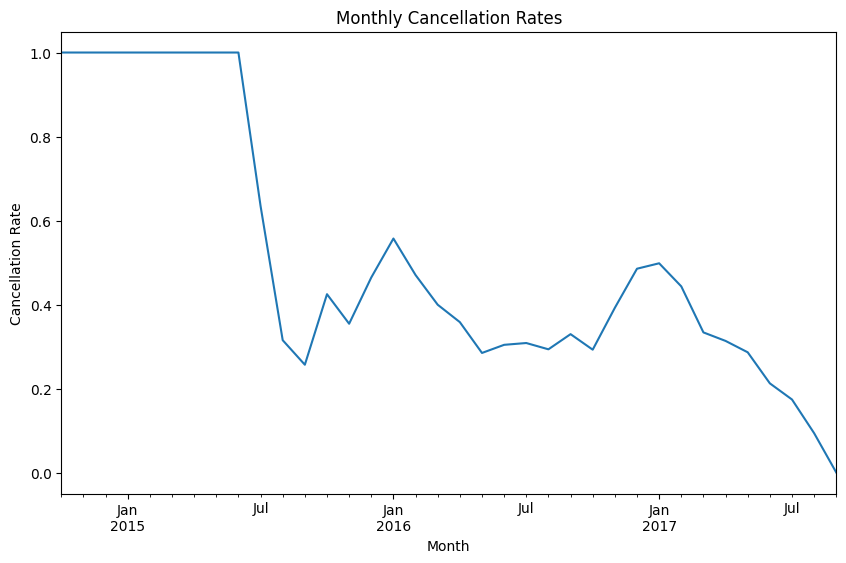

In [18]:

# Time Series Analysis
data_clean['reservation_status_date'] = pd.to_datetime(data_clean['reservation_status_date'])
time_series = data_clean.groupby(data_clean['reservation_status_date'].dt.to_period('M'))['is_canceled'].mean()
time_series.plot(kind='line', figsize=(10, 6), title='Monthly Cancellation Rates')
plt.xlabel('Month')
plt.ylabel('Cancellation Rate')
plt.show()


In [19]:

# Anomaly Detection
lead_time_mean = data_clean['lead_time'].mean()
lead_time_std = data_clean['lead_time'].std()
anomalies = data_clean[(data_clean['lead_time'] > lead_time_mean + 3 * lead_time_std) | (data_clean['lead_time'] < lead_time_mean - 3 * lead_time_std)]
print("Anomalies in Lead Time:")
print(anomalies[['lead_time', 'is_canceled']])


Anomalies in Lead Time:
        lead_time  is_canceled
1             737            0
890           460            0
4182          709            0
5704          468            1
5705          468            1
...           ...          ...
119102        518            0
119107        518            0
119109        518            0
119111        518            0
119148        457            0

[1454 rows x 2 columns]


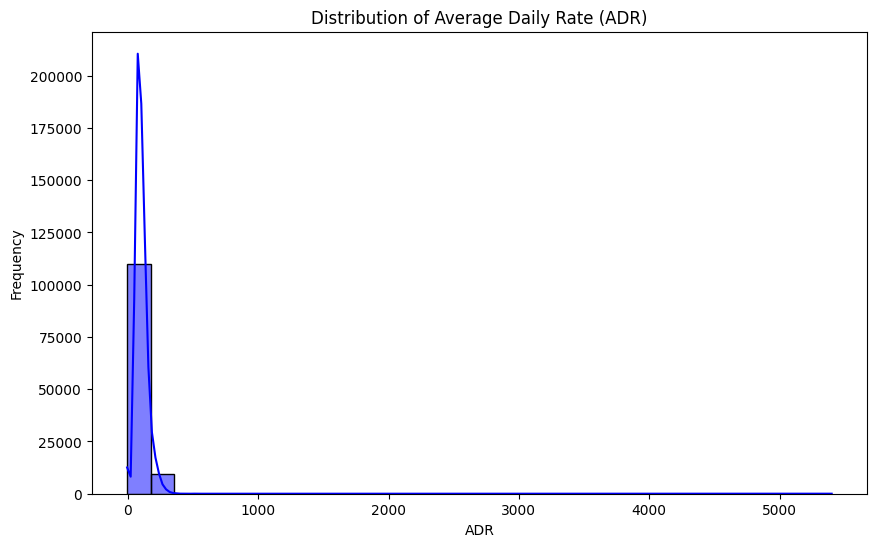

In [20]:

# Additional Visualizations
# 1. Distribution of ADR (Average Daily Rate)
plt.figure(figsize=(10, 6))
sns.histplot(data_clean['adr'], kde=True, bins=30, color='blue')
plt.title('Distribution of Average Daily Rate (ADR)')
plt.xlabel('ADR')
plt.ylabel('Frequency')
plt.show()


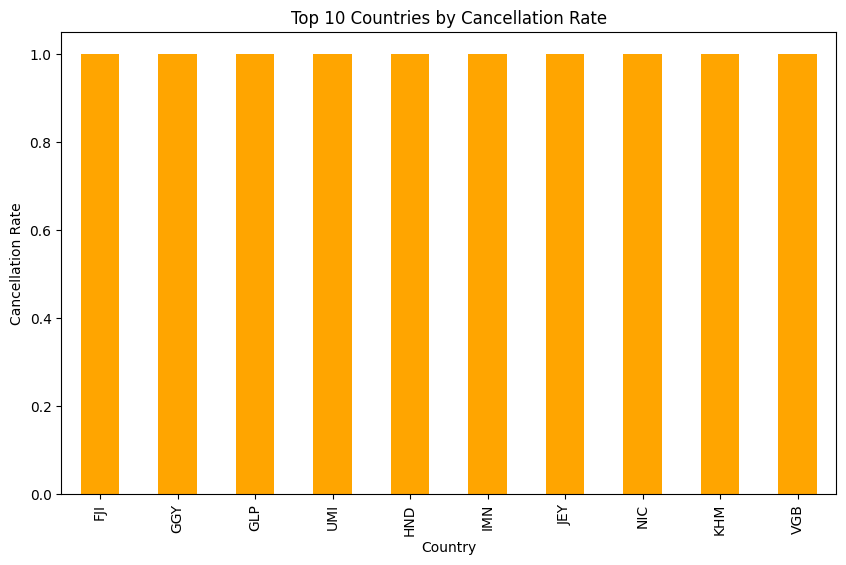

In [21]:
# 2. Cancellation Rates by Country
country_cancellation = data_clean.groupby('country')['is_canceled'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10, 6))
country_cancellation.plot(kind='bar', color='orange')
plt.title('Top 10 Countries by Cancellation Rate')
plt.xlabel('Country')
plt.ylabel('Cancellation Rate')
plt.show()

In [24]:
# 3. Correlation Heatmap
plt.figure(figsize=(12, 8))
corr = data_clean.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

ValueError: could not convert string to float: 'Resort Hotel'

<Figure size 1200x800 with 0 Axes>

# Phase 6: Summary and Insights

## Key Findings
- **Cancellation Trends**: Resort hotels have higher cancellation rates compared to city hotels.
- **Lead Time**: Longer lead times are associated with higher cancellation rates.
- **Market Segment**: Online bookings show distinct cancellation patterns.

## Recommendations
- Offer discounts for early bookings to reduce cancellations.
- Focus on improving customer experience for resort hotels.
- Analyze additional datasets (e.g., weather data) for deeper insights.

## Next Steps
- Deploy the predictive model using a web application (e.g., Flask or Streamlit).
- Enhance the model with hyperparameter tuning.
- Automate the pipeline using tools like Airflow or Prefect.